# CNN_Pseudo

### References:
- https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99
- https://www.kaggle.com/jamesrequa/keras-k-fold-inception-v3-1st-place-lb-0-99770

In [1]:
import os
import time

project_name = 'Digit_Recognizer'
step_name = 'CNN_Pseudo'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())

In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [4]:
train_file = ".\\input\\train.csv"
test_file = ".\\input\\test.csv"
# output_file = ".\\output\\submission.csv"

In [5]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

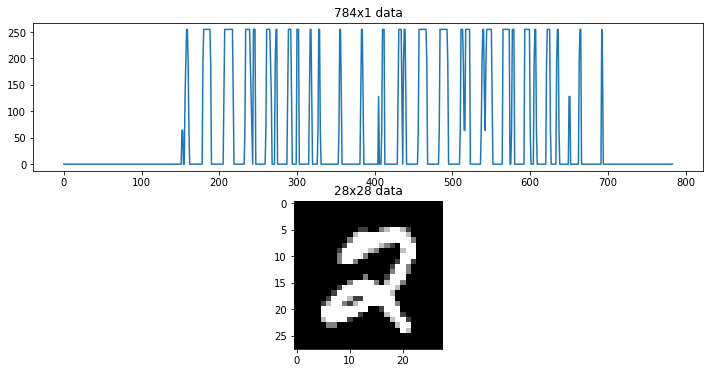

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

(37800, 784)
(37800, 28, 28, 1)
(28, 28, 1)


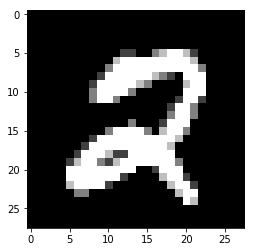

In [7]:
print(x_train.shape)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
print(x_train.shape)
print(x_train[0].shape)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [8]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

In [9]:
print(y_train[0])
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

2
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [10]:
def build_model(input_shape):
    model = Sequential()
    # Block 1
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'Same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.25))
    # Block 2
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.25))

    # Output
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [11]:
model = build_model(x_train.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [12]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [13]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range = 20,
    height_shift_range = 0.2,
    width_shift_range = 0.2
)

val_datagen = ImageDataGenerator()

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.995 ** x)

# def get_lr(x):
#     lr = round(1e-4 * 0.995 ** x, 6)
#     if lr < 5e-5:
#         lr = 5e-5
#     print(lr, end='  ')
#     return lr
# annealer = LearningRateScheduler(get_lr)

callbacks = [annealer]

In [15]:
%%time
batch_size = 128
steps_per_epoch = x_train.shape[0] / batch_size
hist = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size, seed=2018),
    steps_per_epoch=steps_per_epoch,
    epochs=6, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
    max_queue_size=256,
    workers=32,
    validation_steps=1000,
    validation_data=val_datagen.flow(x_val, y_val, batch_size=32, seed=2018)
)

Epoch 1/6
296/295 [==============================] - 23s 79ms/step - loss: 1.8837 - acc: 0.3545 - val_loss: 6.3156 - val_acc: 0.1055
Epoch 2/6
296/295 [==============================] - 23s 79ms/step - loss: 0.9098 - acc: 0.6906 - val_loss: 0.3711 - val_acc: 0.8974
Epoch 3/6
296/295 [==============================] - 26s 87ms/step - loss: 0.5520 - acc: 0.8202 - val_loss: 0.1344 - val_acc: 0.9588
Epoch 4/6
296/295 [==============================] - 26s 88ms/step - loss: 0.4137 - acc: 0.8691 - val_loss: 0.1025 - val_acc: 0.9693
Epoch 5/6
296/295 [==============================] - 25s 86ms/step - loss: 0.3308 - acc: 0.8963 - val_loss: 0.0837 - val_acc: 0.9755
Epoch 6/6
296/295 [==============================] - 23s 78ms/step - loss: 0.2766 - acc: 0.9138 - val_loss: 0.0716 - val_acc: 0.9788
Wall time: 2min 52s


Final loss: 0.0716, final accuracy: 0.9788


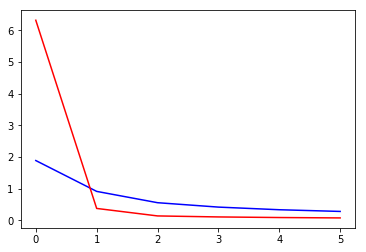

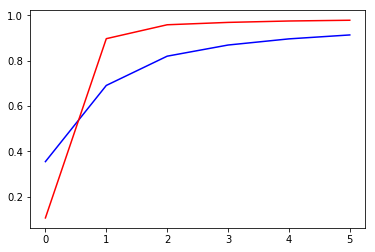

In [16]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

accuracy_score: 0.97880952381
[[432   0   0   0   0   0   2   0   2   0]
 [  0 443   3   2   0   0   0   1   0   0]
 [  0   2 430   3   1   0   0   3   2   0]
 [  1   1   3 433   0   0   0   2   2   2]
 [  0   1   0   0 381   0   1   1   0   4]
 [  0   1   1   4   0 374   0   1   3   2]
 [  1   1   0   0   0   0 415   0   1   0]
 [  0   1   3   0   0   0   0 418   0   3]
 [  2   0   0   0   3   1   1   2 368   3]
 [  1   1   0   2   2   2   1   5   2 417]]
count: 89
(89,)


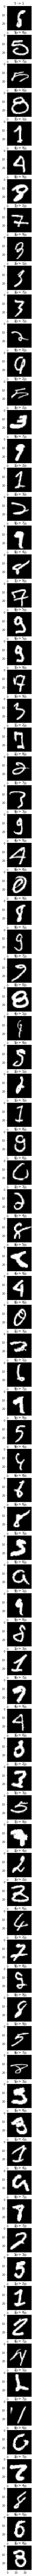

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
def show_diffs(model, x_data, y_data, labels):
    y_hat = model.predict(x_data)
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_data, axis=1)
    print('accuracy_score: %s' % accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels)
    print(cm)
    indexes = []
    diffs = []
    for i, p in enumerate(zip(y_true, y_pred)):
        if p[0] != p[1]:
            indexes.append(i)
            diffs.append(p)
    count = len(indexes)
    print('count: %s' % count)
    figs, axes = plt.subplots(count, 1, figsize=(count,180))
    print(axes.shape)
    for i, p in enumerate(diffs):
        axes[i].imshow(x_val[indexes[i]].reshape(28, 28), cmap='gray')
        axes[i].set_title('%s -> %s' % (p[0], p[1]))
        
show_diffs(model, x_val, y_val, labels=list(range(0, 10)))

### Predict

In [18]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [19]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)
saveModel(model, run_name_acc)

Digit_Recognizer_CNN_Pseudo_20180114_173944_9788


In [20]:
cwd = os.getcwd()
output_file = os.path.join(cwd, 'output', run_name_acc + '.csv')
print(output_file)

E:\Kaggle\digit-recognizer\output\Digit_Recognizer_CNN_Pseudo_20180114_173944_9788.csv


In [21]:
y_hat = model.predict(x_test, batch_size=64)
y_pred = np.argmax(y_hat,axis=1)

with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

### Pseudo Labeling

In [22]:
ps_y_test = model.predict(x_test, batch_size=64)
print(ps_y_test.shape)

(28000, 10)


In [23]:
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

print(x_test.shape)
print(ps_y_test.shape)

(37800, 28, 28, 1)
(4200, 28, 28, 1)
(37800, 10)
(4200, 10)
(28000, 28, 28, 1)
(28000, 10)


In [24]:
ps_x_data = np.concatenate([x_train, x_val, x_test], axis=0)
ps_y_data = np.concatenate([y_train, y_val, ps_y_test], axis=0)
print(ps_x_data.shape)
print(ps_y_data.shape)

(70000, 28, 28, 1)
(70000, 10)


In [25]:
x_train, x_val, y_train, y_val = train_test_split(ps_x_data, ps_y_data, test_size=0.02)
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

(68600, 28, 28, 1)
(1400, 28, 28, 1)
(68600, 10)
(1400, 10)


In [26]:
model = build_model(x_train.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [27]:
%%time
batch_size = 128
steps_per_epoch = x_train.shape[0] / batch_size
hist = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size, seed=2018),
    steps_per_epoch=steps_per_epoch,
    epochs=6, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
    max_queue_size=256,
    workers=32,
    validation_steps=1000,
    validation_data=val_datagen.flow(x_val, y_val, batch_size=32, seed=2018)
)

Epoch 1/6
536/535 [==============================] - 46s 85ms/step - loss: 1.4010 - acc: 0.5258 - val_loss: 0.8609 - val_acc: 0.7329
Epoch 2/6
536/535 [==============================] - 47s 87ms/step - loss: 0.5111 - acc: 0.8381 - val_loss: 0.1554 - val_acc: 0.9536
Epoch 3/6
536/535 [==============================] - 48s 90ms/step - loss: 0.3311 - acc: 0.8988 - val_loss: 0.1001 - val_acc: 0.9736
Epoch 4/6
536/535 [==============================] - 48s 90ms/step - loss: 0.2617 - acc: 0.9218 - val_loss: 0.0729 - val_acc: 0.9829
Epoch 5/6
536/535 [==============================] - 46s 87ms/step - loss: 0.2223 - acc: 0.9355 - val_loss: 0.0662 - val_acc: 0.9864
Epoch 6/6
536/535 [==============================] - 47s 87ms/step - loss: 0.1982 - acc: 0.9435 - val_loss: 0.0630 - val_acc: 0.9857
Wall time: 5min 8s


Final loss: 0.0630, final accuracy: 0.9857


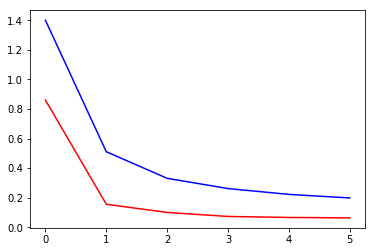

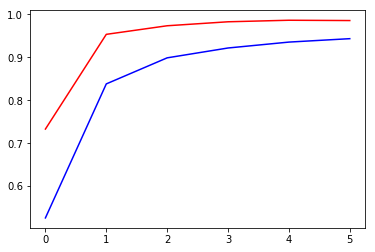

In [28]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

accuracy_score: 0.985714285714
[[166   0   0   0   0   0   0   0   0   0]
 [  0 150   0   0   0   0   0   0   0   0]
 [  0   1 136   1   0   0   0   0   0   0]
 [  1   0   0 135   0   1   0   1   1   0]
 [  0   0   0   0 140   0   0   0   0   0]
 [  0   0   0   1   0 115   0   0   1   1]
 [  0   0   0   0   0   0 140   0   0   0]
 [  0   1   0   0   0   0   0 119   0   0]
 [  1   0   0   0   0   1   1   1 134   3]
 [  0   0   0   0   2   0   0   0   1 145]]
count: 20
(20,)


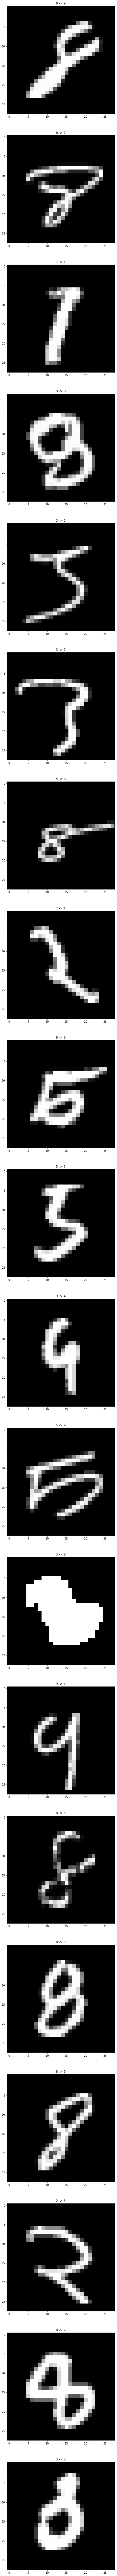

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
def show_diffs(model, x_data, y_data, labels):
    y_hat = model.predict(x_data)
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_data, axis=1)
    print('accuracy_score: %s' % accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels)
    print(cm)
    indexes = []
    diffs = []
    for i, p in enumerate(zip(y_true, y_pred)):
        if p[0] != p[1]:
            indexes.append(i)
            diffs.append(p)
    count = len(indexes)
    print('count: %s' % count)
    figs, axes = plt.subplots(count, 1, figsize=(count,180))
    print(axes.shape)
    for i, p in enumerate(diffs):
        axes[i].imshow(x_val[indexes[i]].reshape(28, 28), cmap='gray')
        axes[i].set_title('%s -> %s' % (p[0], p[1]))
        
show_diffs(model, x_val, y_val, labels=list(range(0, 10)))

## After Pseudo Labeling Predict

In [34]:
import time
import os

final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_AfterPseudo_' + final_acc_str
print(run_name_acc)
saveModel(model, run_name_acc)

cwd = os.getcwd()
output_file = os.path.join(cwd, 'output', run_name_acc + '.csv')
print(output_file)

Digit_Recognizer_CNN_Pseudo_20180114_173944_AfterPseudo_9857
E:\Kaggle\digit-recognizer\output\Digit_Recognizer_CNN_Pseudo_20180114_173944_AfterPseudo_9857.csv


In [35]:
y_hat = model.predict(x_test, batch_size=64)
y_pred = np.argmax(y_hat,axis=1)

with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

In [36]:
print('Done!')

Done!
